# Introduction to Machine Learning (CSCI-UA.473)

### Homework 3
#### Due: November 12th, 2023 at 11:59PM


#### Name: Yiqi Rao
#### Email: yr2071@nyu.edu

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from IPython.display import Image

In [ ]:
# Set up a transform to convert the images to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

num_train = len(trainset)
num_val = int(0.1 * num_train)
num_train -= num_val

train_dataset, val_dataset = random_split(trainset, [num_train, num_val])

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 75280344.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Question 1: Data Visualization (15 points)

**Task 1.1 (3 points):** Perform the following visualizations in a single plot with 5 subplots:
- Display five random images along with their corresponding labels.
- Create a bar plot to visualize the distribution of classes in the CIFAR-10 dataset.

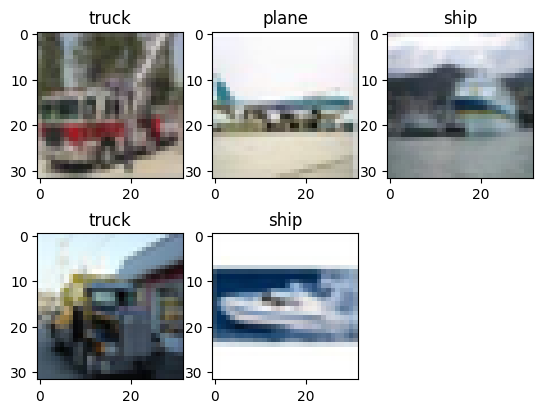

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
imgid = np.random.randint(0,len(trainset),5)
plt.figure()
for i in range(5):
  img = trainset[imgid[i]][0]
  label = classes[trainset[imgid[i]][1]]
  plt.subplot(2,3,i+1)
  plt.imshow(transforms.ToPILImage()(img))
  plt.title(label)

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


<BarContainer object of 10 artists>

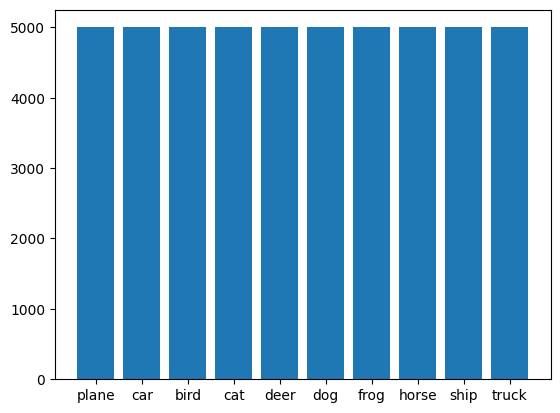

In [ ]:
counts=[0,0,0,0,0,0,0,0,0,0]
for i in range(len(trainset)):
  counts[trainset[i][1]-1]+=1
print(counts)
plt.bar(classes, counts)

**Task 1.2 (5 points):**  Perform the following data augmentation on the images of the training dataset:
*   RandomCrop with a 32-pixel crop size and 4 pixel padding
*   RandomHorizontalFlip
*   Any other augmentation of your choice

Choose a couple of random images from the training set and display the original image and the augmented images next to each other. Which augmentation did you try?  

**Task 1.3 (3 points):** Standardization of images is a preprocessing step used to normalize the pixel values of the images. To standardize an image, we subtract the mean value from each pixel, and then divide the result by the standard deviation.

Standardize the image by applying mean values $(0.4914, 0.4822, 0.4465)$ and standard deviation values $(0.2023, 0.1994, 0.2010)$.

Hint: Look into torchvision.transforms.Normalize()


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


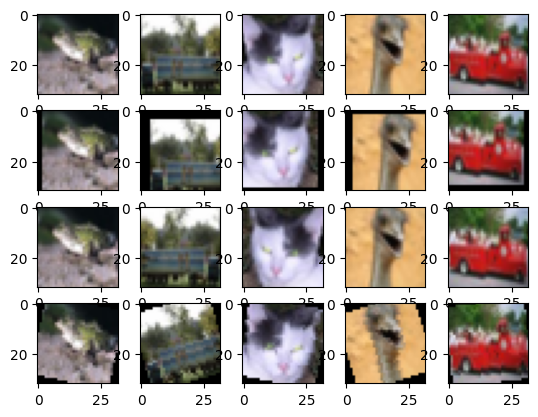

In [ ]:
## Add code here
trainsets=[]
trainsets.append(trainset)
trainsets.append(torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.RandomCrop(32,4),transforms.ToTensor()])))
trainsets.append(torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor()])))
trainsets.append(torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.RandomRotation(20),transforms.ToTensor()])))

imgid = np.random.randint(0,50000,5)
plt.figure()
for i in range(5):
  for j in range(4):
    img = trainsets[j][imgid[i]][0]
    plt.subplot(4,5,i+5*j+1)
    plt.imshow(transforms.ToPILImage()(img))

I used RandomCrop, RandomHorizontalFlip, and RandomRotation of 20 degrees.

In [ ]:
normalized_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)),transforms.ToTensor()]))

Files already downloaded and verified


**Task 1.4 (4 points):** Create the train, validation and test data loaders with a batch size of 64 and four workers. Explain the roles of the shuffle parameter and the number of workers parameter.

In [ ]:
## Add code here
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The shuffle parameter would determine if the data would be shuffled at every epoch. And num_workers parameter shows how many subprocesses is going to parallel for data loading.



### Question 2: MLP architecture (10 points)

**Task 2.1 (5 points):** Complete the following architecture for MLP to train the CIFAR-10 dataset.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 128)                 # output size is 128
        self.fc2 = nn.Linear(128, 64)                    # Hidden layer with 64 units
        self.fc3 = nn.Linear(64, 10)                    # Output layer with 10 units (classes)

    def forward(self, x):
        # Flattened input -> FC1 -> ReLU -> FC2 -> ReLU -> Output
        layers = nn.Sequential(
            nn.Flatten(),
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.ReLU(),
            self.fc3
        )
        x = layers(x)
        return x

# Create an instance of the model
model = MLP()

**Task 2.2 (3 points):** Specify the training configuration as follows:
- Use the SGD optimizer with weight_decay=1e-4. What does this parameter mean?
- Use 64 batch size.


In [ ]:
## Add code here
from torch.optim import SGD
optimizer = SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

**Task 2.3 (2 points)** Train the MLP for 10 epochs in the code-cell below, where an epoch is defined as one full pass over the training set.

In [ ]:
## Add code here
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    for batch_idx, (data, targets) in enumerate(train_loader):
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Train Epoch: 0 [0/45000 (0%)]	Loss: 2.310080
Train Epoch: 0 [6400/45000 (14%)]	Loss: 2.083073
Train Epoch: 0 [12800/45000 (28%)]	Loss: 2.008378
Train Epoch: 0 [19200/45000 (43%)]	Loss: 1.902190
Train Epoch: 0 [25600/45000 (57%)]	Loss: 2.130433
Train Epoch: 0 [32000/45000 (71%)]	Loss: 1.613563
Train Epoch: 0 [38400/45000 (85%)]	Loss: 1.936216
Train Epoch: 0 [44800/45000 (99%)]	Loss: 1.794174
Train Epoch: 1 [0/45000 (0%)]	Loss: 2.074752
Train Epoch: 1 [6400/45000 (14%)]	Loss: 1.574271
Train Epoch: 1 [12800/45000 (28%)]	Loss: 1.885329
Train Epoch: 1 [19200/45000 (43%)]	Loss: 1.742260
Train Epoch: 1 [25600/45000 (57%)]	Loss: 1.865213
Train Epoch: 1 [32000/45000 (71%)]	Loss: 1.480794
Train Epoch: 1 [38400/45000 (85%)]	Loss: 1.902591
Train Epoch: 1 [44800/45000 (99%)]	Loss: 1.665791
Train Epoch: 2 [0/45000 (0%)]	Loss: 1.979980
Train Epoch: 2 [6400/45000 (14%)]	Loss: 1.485700
Train Epoch: 2 [12800/45000 (28%)]	Loss: 1.807977
Train Epoch: 2 [19200/45000 (43%)]	Loss: 1.659458
Train Epoch: 2 [25

### Question 3: Convolution network (38 points)


**Task 3.1 (10 points):** You are tasked with creating a neural network architecture that includes a novel structural unit. This unit is designed to facilitate the training of very deep networks by enabling the flow of information through shortcuts. The architecture of this unit can be described as follows:

1. **Main Path:**
   - The main path should consist of two convolutional layers, each followed by a batch normalization layer and a ReLU activation function.
   - You can choose the filter sizes and the number of filters for each convolutional layer.

2. **Shortcut Path:**
   - The shortcut path should provide a direct, unaltered connection from the input to the output of this unit.
   - No additional weights or non-linear transformations are applied to this path; it is a simple identity mapping.

3. **Combining Paths:**
   - The key concept of this unit is adding the output of the shortcut path to the output of the main path.
   - This addition operation should be performed element-wise, meaning that the feature maps from both paths are element-wise summed.

You need to implement this architectural unit below.

In [ ]:
# Define a custom architectural block class that inherits from nn.Module
class ArchitecturalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super(ArchitecturalBlock, self).__init__()

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Store parameters for downsampling and stride
        self.down_sample = down_sample
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

    # Define a method for down-sampling
    def down_sampling(self, x):
        # Implement down-sampling here using the appropriate method or layer
        datasampling = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=self.stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1))
        out = datasampling(x)
        return out

    # Define the forward pass for the block
    def forward(self, x):
        # Save a copy of the input for the residual connection
        shortcut = x
        # Apply the first convolutional layer, batch normalization, and ReLU activation
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # Apply the second convolutional layer and batch normalization
        x = self.conv2(x)
        x = self.bn2(x)
        # Implement down-sampling here using the down_sampling method
        if self.down_sample:
          shortcut = self.down_sampling(shortcut)
        # Add the shortcut connection to the output and apply ReLU thereafter
        out = x + shortcut
        out = self.relu(out)
        return out

**Task 3.2 (10 points):** Now implement `Model` class. Assume the `block` argument will be `ArchitecturalBlock` we implemented above. Here are required implementation details.

* In `init` method, specifiy all details of convolution, batch norm layers.
* In `get_layers` method, set down_sample boolean variable according to the stride information. Then, define a list of architectural blocks (`layer_list`). Make sure the down-sample only occurs at the first block in demand.

In [ ]:
class Model(nn.Module):
    def __init__(self, num_layers, block, num_classes=10):
        super(Model, self).__init__()
        self.num_layers = num_layers

        # input(channel:3) -> (conv 3x3) -> (bn) -> (relu) -> output(channel:16)
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        # feature map size = 16x32x32
        self.layers_2n = self.get_layers(block, 16, 16, stride=1)
        # feature map size = 32x16x16
        self.layers_4n = self.get_layers(block, 16, 32, stride=2)
        # feature map size = 64x8x8
        self.layers_6n = self.get_layers(block, 32, 64, stride=2)

        # output layers
        self.avg_pool = nn.AvgPool2d(8, stride=1)
        self.fc_out = nn.Linear(64, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def get_layers(self, block, in_channels, out_channels, stride):
        if stride == 2:
            down_sample = True
        else:
            down_sample = False

        layer_list = nn.ModuleList([block(in_channels, out_channels, stride, down_sample)])
        for i in range(1, self.num_layers):
          layer_list.append(block(out_channels, out_channels,))
        return nn.Sequential(*layer_list)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layers_2n(x)
        x = self.layers_4n(x)
        x = self.layers_6n(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)

        return x

In [ ]:
def model():
    block = ArchitecturalBlock
    model = Model(3, block)
    return model

**Task 3.3 (5 points):** Use the model training configuration as follows to train the model:
- Use the SGD optimizer with weight_decay=1e-4.
- Use 64 batch size.
- The learning rate starts from 0.1 and is decayed at 32,000 and 48,000 step with 0.1 factor.

In [ ]:
## add code here
from torch.optim import lr_scheduler
model = model()
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.1, weight_decay=1e-4)
lrscheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
train_loss_epoch = []
for epoch in range(10):
    total_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    lrscheduler.step()
    train_loss_epoch.append(total_loss)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Epoch: 0 [0/45000 (0%)]	Loss: 2.527187
Train Epoch: 0 [6400/45000 (14%)]	Loss: 1.794192
Train Epoch: 0 [12800/45000 (28%)]	Loss: 2.017596
Train Epoch: 0 [19200/45000 (43%)]	Loss: 1.780087
Train Epoch: 0 [25600/45000 (57%)]	Loss: 1.717021
Train Epoch: 0 [32000/45000 (71%)]	Loss: 1.446084
Train Epoch: 0 [38400/45000 (85%)]	Loss: 1.447963
Train Epoch: 0 [44800/45000 (99%)]	Loss: 1.521343
Train Epoch: 1 [0/45000 (0%)]	Loss: 1.710627
Train Epoch: 1 [6400/45000 (14%)]	Loss: 1.259347
Train Epoch: 1 [12800/45000 (28%)]	Loss: 1.690876
Train Epoch: 1 [19200/45000 (43%)]	Loss: 1.572856
Train Epoch: 1 [25600/45000 (57%)]	Loss: 1.233228
Train Epoch: 1 [32000/45000 (71%)]	Loss: 1.172228
Train Epoch: 1 [38400/45000 (85%)]	Loss: 1.213626
Train Epoch: 1 [44800/45000 (99%)]	Loss: 1.345494
Train Epoch: 2 [0/45000 (0%)]	Loss: 1.251572
Train Epoch: 2 [6400/45000 (14%)]	Loss: 0.953238
Train Epoch: 2 [12800/45000 (28%)]	Loss: 1.316405
Train Epoch: 2 [19200/45000 (43%)]	Loss: 1.294033
Train Epoch: 2 [25

**Task 3.4 (3 points):** Plot train loss and calculate test performance. Save the best model by implementing early stopping during training.

Early stopping is a form of regularization used to avoid overfitting when training a machine learning model. It works by monitoring the model's performance on a validation set and stopping the training process once the model's performance ceases to improve, or even starts to deteriorate, on this out-of-sample data. This ensures that we train the model just until it is optimal and not beyond, which can save computational resources and prevent the model from learning the noise in the training set.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Accuracy: 71.910%


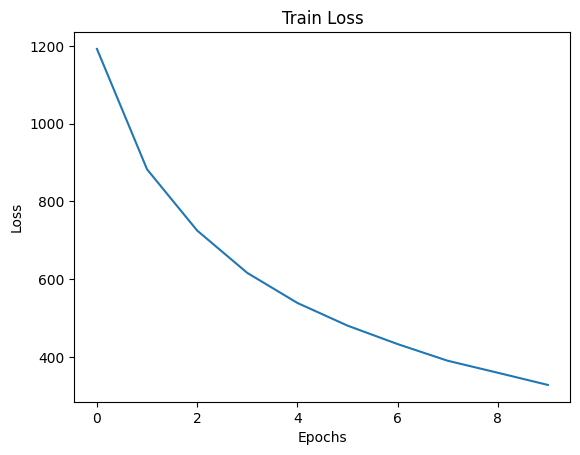

In [ ]:
## Add code for test performance here
plt.plot(train_loss_epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss')

model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

accuracy1 = (100 * correct / len(test_loader.dataset))
print(f"Test Accuracy: {accuracy1:.3f}%")

**Task 3.5 (5 points):** Create a copy of the Architecture block but without the shortcut connection in this case. Train the model with early stopping and compare it to the above model that uses the shortcut connection and MLP using a bar chart.

In [ ]:
## Add code here
class ArchitecturalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super(ArchitecturalBlock, self).__init__()

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        # Store parameters for downsampling and stride
        self.down_sample = down_sample
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

    # Define a method for down-sampling
    def down_sampling(self, x):
        # Implement down-sampling here using the appropriate method or layer
        downsampling = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=self.stride, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1))
        out = downsampling(x)
        return out

    # Define the forward pass for the block
    def forward(self, x):
        # Apply the first convolutional layer, batch normalization, and ReLU activation
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        # Apply the second convolutional layer and batch normalization
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

In [ ]:
def model():
    block = ArchitecturalBlock
    model = Model(3, block)
    return model

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Epoch: 0 [0/45000 (0%)]	Loss: 2.306584
Train Epoch: 0 [6400/45000 (14%)]	Loss: 2.025370
Train Epoch: 0 [12800/45000 (28%)]	Loss: 1.894040
Train Epoch: 0 [19200/45000 (43%)]	Loss: 1.725634
Train Epoch: 0 [25600/45000 (57%)]	Loss: 1.748791
Train Epoch: 0 [32000/45000 (71%)]	Loss: 1.776530
Train Epoch: 0 [38400/45000 (85%)]	Loss: 1.495993
Train Epoch: 0 [44800/45000 (99%)]	Loss: 1.431803
Train Epoch: 1 [0/45000 (0%)]	Loss: 2.107831
Train Epoch: 1 [6400/45000 (14%)]	Loss: 1.251825
Train Epoch: 1 [12800/45000 (28%)]	Loss: 1.772622
Train Epoch: 1 [19200/45000 (43%)]	Loss: 1.347648
Train Epoch: 1 [25600/45000 (57%)]	Loss: 1.375694
Train Epoch: 1 [32000/45000 (71%)]	Loss: 1.299702
Train Epoch: 1 [38400/45000 (85%)]	Loss: 1.034675
Train Epoch: 1 [44800/45000 (99%)]	Loss: 1.307878
Train Epoch: 2 [0/45000 (0%)]	Loss: 1.628437
Train Epoch: 2 [6400/45000 (14%)]	Loss: 1.077368
Train Epoch: 2 [12800/45000 (28%)]	Loss: 1.421123
Train Epoch: 2 [19200/45000 (43%)]	Loss: 1.168147
Train Epoch: 2 [25

Text(0.5, 1.0, 'Train Loss')

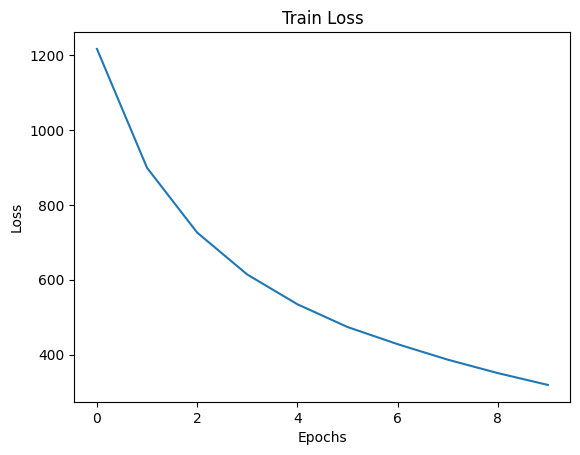

In [ ]:
model = model()
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.1, weight_decay=1e-4)
lrscheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[32000, 48000], gamma=0.1)
train_loss_epoch = []
min_val_loss = float('inf')
patience = 2
for epoch in range(10):
    model.train()
    total_loss = 0
    wait = 0
    for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    lrscheduler.step()
    train_loss_epoch.append(total_loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data_val, target_val in val_loader:
            output_val = model(data_val)
            loss = criterion(output_val, target_val)
            val_loss += loss.item()
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            wait+=1
            if wait >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

plt.plot(train_loss_epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss')

In [ ]:
def model():
    block = ArchitecturalBlock
    model = Model(3, block)
    return model

Test Accuracy: 71.950%


<BarContainer object of 2 artists>

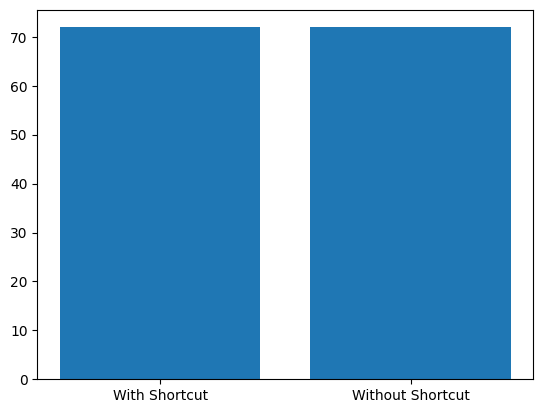

In [ ]:
best_model = model()
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = best_model(data)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

accuracy2 = (100 * correct / len(test_loader.dataset))
print(f"Test Accuracy: {accuracy2:.3f}%")

models = ['With Shortcut','Without Shortcut']
acc = [accuracy1, accuracy2]
plt.bar(models, acc)

**Task 3.6 (5 points):** Extract feature maps from one of the convolutional layers. Visualize these feature maps to understand what the network is learning. Can you see something interesting in them? Elaborate.

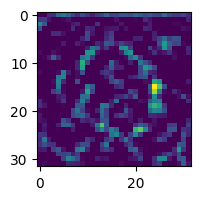

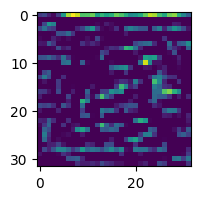

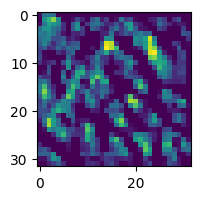

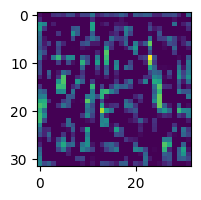

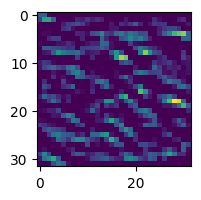

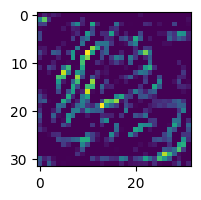

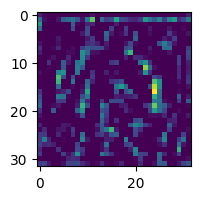

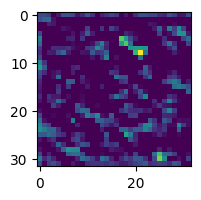

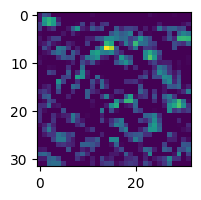

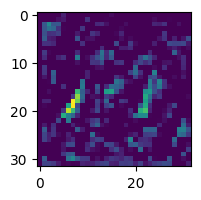

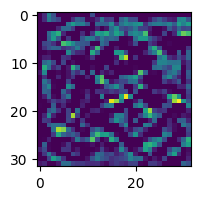

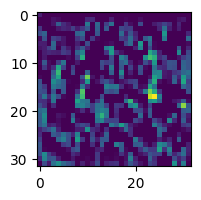

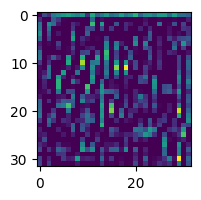

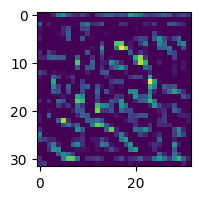

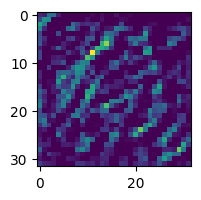

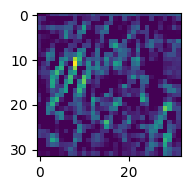

In [ ]:
## Add code here
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

best_model.layers_2n.register_forward_hook(get_activation('layers_2n'))
data, _ = trainset[0]
data.unsqueeze_(0)
output = best_model(data)

act = activation['layers_2n'].squeeze()

for idx in range(act.size(0)):
  fig, axarr = plt.subplots(figsize=(2,2))
  axarr.imshow(act[idx])
plt.tight_layout()

The feature maps have similar colors and in a similar pattern (all with some lines or shapes in green and blue in background).

### Question 4: Recurrent Neural Networks (7 points)

**Task 4.1 (7 points):** Implement a RNN from scratch

**PARAMETERS**

*   **input_size**: the number of expected features in the input x
*   **hidden_size**: the number of features in the hidden state h
*   **num_layers**: number of recurrent layers
*   **bidirectional**: if `True`, becomes bidirectional RNN
*   **batch_first**: if `True`, the input and output tensors are provided as `(batch, seq, feature)`


**INPUT**
*    **input**: data of shape (batch_size, seq_len, input_size) if **batch_first** = `True`
*    **h0**: tensor containing the initial hidden state of shape (num_layers * num_directions, batch_size, hidden_size)


**OUTPUT**
*    **output**: tensor containing the output features from the last layer of the RNN, for each t provided as `(batch, seq, hidden_size)` if **batch_first** = `True`
*    **hidden**: tensor containing the hidden state for the last time step, provided as `(batch, num_layers * num_directionals, hidden_size)` if **batch_first** = `True`



Detailed explanation and default values are available on the official site
(https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers = 1, bidirectional = False, batch_first = False):
      super(RNN, self).__init__()
      self.num_layers = num_layers
      self.bidirectional = bidirectional
      self.batch_first = batch_first
      self.hidden_size = hidden_size
      self.W = nn.Linear(input_size, hidden_size)
      self.U = nn.Linear(hidden_size, hidden_size)
      self.V = nn.Linear(hidden_size, output_size)
      self.softmax = nn.LogSoftmax(dim=1)

  torch.nn.RNN

  def forward(self, x, h):
      h = self.U(h)
      x = self.W(x)
      h = torch.tanh(x+h)
      y = self.V(h)

      return y, h

In [ ]:
# input_size = 3
# hidden_size = 4

x = torch.randn(1, 3)   # batch_size, feature
h = torch.randn(1, 4)  # batch_size, hidden_size
rnn = RNN(input_size = 3, hidden_size = 4, output_size = 4)
output, hidden = rnn(x, h)

print('output shape:', output.shape)
print('output:', output.data)
print('hidden shape:', hidden.shape)
print('hidden:', hidden.data)

output shape: torch.Size([1, 4])
output: tensor([[ 0.7527, -0.1111,  1.1228, -0.4178]])
hidden shape: torch.Size([1, 4])
hidden: tensor([[-0.1905, -0.8102,  0.5402,  0.5003]])
